# Convolution-based Denoising with Fourier transforms

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '../build/'))
import pydeft as deft

Consider a simple cubic lattice (with unit spacing) together with the three-dimensional function

$$
w(\mathbf{r}) = \cos (4\pi x) ,
$$

which has the periodicity of the lattice but varies only in the $x$ direction.

To demonstrate the use of DEFT for denoising, let us consider adding some noise to this signal in real space. Given the scale of the cosine function, let us add random perturbations from the range $[-0.2,0.2]$.

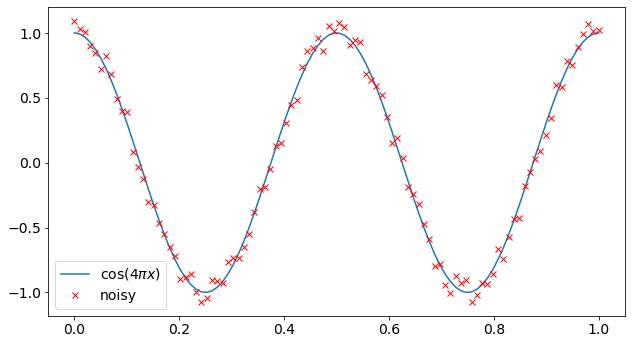

In [2]:
# create f(r) = cos(4*pi*x) 
x = np.linspace(0, 1, 100)
X,Y,Z = np.meshgrid(x,x,x, indexing='ij')

f = np.cos(4*np.pi*X)

# add noise
noisy_f = f + 0.2*(np.random.rand(x.size,x.size,x.size) - 0.5)

fig = plt.figure(figsize=[9,5])
plt.rc('font', size=14)
plt.plot(x, [f[i,0,0] for i in range(x.size)])
plt.plot(x, [noisy_f[i,0,0] for i in range(x.size)], 'xr')
plt.legend(['cos$(4\pi x)$', 'noisy'])
plt.tight_layout()
plt.show()

 We can then apply a convolutional filter/low-pass filter in reciprocal space to recover the original function. For this example, we choose a top-hat filter of the form 
$$
F_\text{top-hat}(\mathbf{k}) = \left\{
\begin{array}{ll}
     1 & \text{for} ~~|\mathbf{k}|<k_0 \\
     0 & \text{otherwise}\\
\end{array} 
\right. 
$$

This is equivalent to convolving the noisy function with a sinc function in real space.

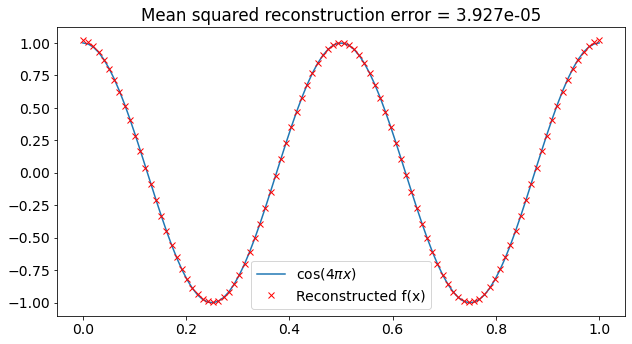

In [3]:
f_deft = deft.Double3D((x.size,x.size,x.size))
f_deft[...] = f
f_ft = deft.fourier_transform(f_deft) 

noisy_f_deft = deft.Double3D((x.size,x.size,x.size))
noisy_f_deft[...] = noisy_f
f_noisy_ft = deft.fourier_transform(noisy_f_deft)    

k = deft.wave_numbers(f_noisy_ft.shape(), deft.Box(np.eye(3)))
top_hat_filter = deft.Complex3D(f_noisy_ft.shape())
top_hat_filter[...] = np.where(k[...]<25, 1, 0)

filtered_f = deft.inverse_fourier_transform(top_hat_filter*f_noisy_ft, noisy_f_deft.shape())

fig = plt.figure(figsize=[9,5])
plt.rc('font', size=14)
plt.plot(x, [f[i,0,0] for i in range(x.size)])
plt.plot(x, [filtered_f[i,0,0] for i in range(x.size)], 'xr')
plt.legend(['cos$(4\pi x)$', 'Reconstructed f(x)'])
plt.title('Mean squared reconstruction error = {:.4g}'.format(np.mean((filtered_f[...]-f)**2)))
plt.tight_layout()
plt.show()